In [1]:
from google.colab import files
uploaded = files.upload()

Saving X_test.csv to X_test.csv
Saving X_train-2.csv to X_train-2.csv
Saving y_train-1.csv to y_train-1.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [5]:
X_train = pd.read_csv('X_train-2.csv', header=None).values
y_train = pd.read_csv('y_train-1.csv', header=None).values
X_test = pd.read_csv('X_test.csv', header=None).values

In [6]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (350, 7)
Shape of y_train: (350, 1)
Shape of X_test: (42, 7)


In [8]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Initialize the Ridge Regression model
ridge_model = Ridge(alpha=1.0)

# Train the model
ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)


In [9]:
ridge_model.fit(X_train, y_train)

Ridge()

In [10]:
# Calculate predictions for X_test
y_pred_test = ridge_model.predict(X_test)

abs_y_pred_test = np.abs(y_pred_test)

sorted_indices = np.argsort(abs_y_pred_test.flatten())

N = 5
uncertain_sample_indices = sorted_indices[:N]


print("Indices of the most uncertain samples:", uncertain_sample_indices)

Indices of the most uncertain samples: [14 22 28  4 16]


In [11]:
selected_X = X_test[uncertain_sample_indices]

simulated_y_oracle = y_train[uncertain_sample_indices]

newly_labeled_X = selected_X
newly_labeled_y = simulated_y_oracle

print("Shape of newly acquired labeled X:", newly_labeled_X.shape)
print("Shape of newly acquired labeled y:", newly_labeled_y.shape)

Shape of newly acquired labeled X: (5, 7)
Shape of newly acquired labeled y: (5, 1)


In [12]:
# Concatenate the original training features with the newly acquired features
X_train_updated = np.concatenate((X_train, newly_labeled_X), axis=0)

# Concatenate the original training labels with the newly acquired labels
y_train_updated = np.concatenate((y_train, newly_labeled_y), axis=0)

# Retrain the ridge_model using the updated training data
ridge_model.fit(X_train_updated, y_train_updated)

print("Shape of updated X_train:", X_train_updated.shape)
print("Shape of updated y_train:", y_train_updated.shape)
print("Ridge model retrained with updated data.")

Shape of updated X_train: (355, 7)
Shape of updated y_train: (355, 1)
Ridge model retrained with updated data.


In [22]:
from tqdm.auto import tqdm

# Define the number of iterations
num_iterations = 10

# Initialize updated training data
X_train_updated = X_train.copy()
y_train_updated = y_train.copy()

training_data_size_history = [X_train_updated.shape[0]]

for i in tqdm(range(num_iterations), desc="Active Learning Progress"):

    y_pred_test = ridge_model.predict(X_test)

    abs_y_pred_test = np.abs(y_pred_test)

    sorted_indices = np.argsort(abs_y_pred_test.flatten())

    N = 5 # Number of samples to select in each iteration
    uncertain_sample_indices = sorted_indices[:N]

    simulated_oracle_labels = np.sum(X_test[uncertain_sample_indices], axis=1).reshape(-1, 1)


    newly_labeled_X = X_test[uncertain_sample_indices]
    newly_labeled_y = simulated_oracle_labels
    # Use the simulated oracle labels

    X_train_updated = np.concatenate((X_train_updated, newly_labeled_X), axis=0)
    y_train_updated = np.concatenate((y_train_updated, newly_labeled_y), axis=0)


    ridge_model.fit(X_train_updated, y_train_updated)

    training_data_size_history.append(X_train_updated.shape[0])


print("\nActive learning loop finished.")
print("Final training data size:", X_train_updated.shape[0])
print("Training data size history:", training_data_size_history)


Active Learning Progress:   0%|          | 0/10 [00:00<?, ?it/s]


Active learning loop finished.
Final training data size: 400
Training data size history: [350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400]


In [23]:
# Use the retrained ridge_model to make predictions on the X_test dataset
y_pred_test_final = ridge_model.predict(X_test)

y_pred_selected = y_pred_test_final[uncertain_sample_indices]

mse_on_simulated_labels = mean_squared_error(simulated_oracle_labels, y_pred_selected)

print(f"Mean Squared Error on selected X_test samples (using simulated oracle labels): {mse_on_simulated_labels}")

print("\nThis evaluation is based on simulated oracle labels and not true y_test.")

Mean Squared Error on selected X_test samples (using simulated oracle labels): 8.60025265064119

This evaluation is based on simulated oracle labels and not true y_test.


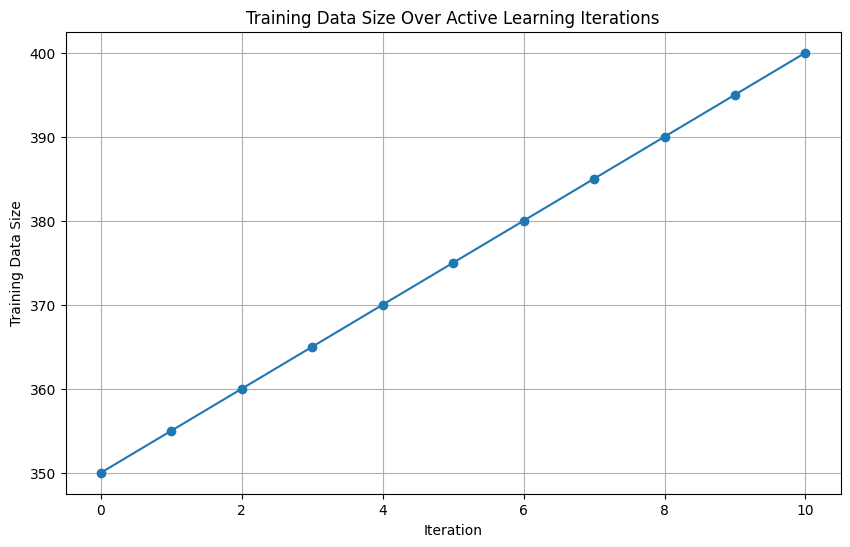

In [15]:
# Plot the training data size over iterations
plt.figure(figsize=(10, 6))
plt.plot(range(len(training_data_size_history)), training_data_size_history, marker='o')
plt.title('Training Data Size Over Active Learning Iterations')
plt.xlabel('Iteration')
plt.ylabel('Training Data Size')
plt.grid(True)
plt.show()

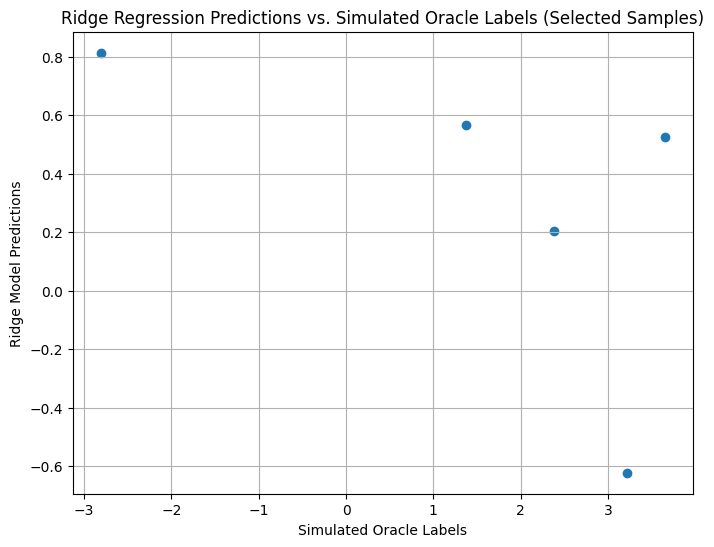

In [24]:
# Visualize the predictions vs. simulated oracle labels for the selected samples
plt.figure(figsize=(8, 6))
plt.scatter(simulated_oracle_labels, y_pred_selected)
plt.title('Ridge Regression Predictions vs. Simulated Oracle Labels (Selected Samples)')
plt.xlabel('Simulated Oracle Labels')
plt.ylabel('Ridge Model Predictions')
plt.grid(True)
plt.show()


MSE of Initial Ridge Model on selected samples (using simulated oracle labels): 14.21142858816325
MSE of Final Active Learning Ridge Model on selected samples (using simulated oracle labels): 8.766803237542915


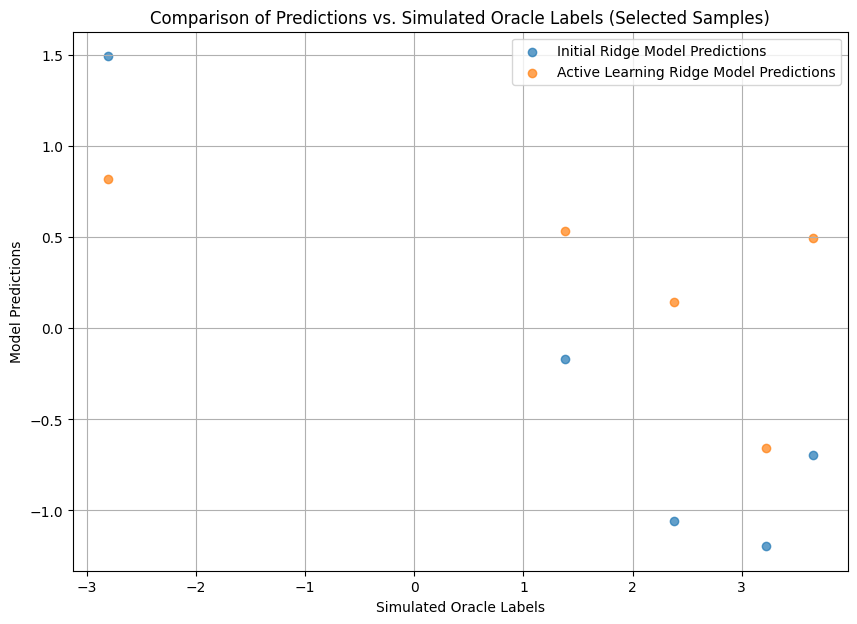


Note: This comparison is based on simulated oracle labels and not true y_test.


In [17]:

ridge_model_initial = Ridge(alpha=1.0) # Use the same alpha as before
ridge_model_initial.fit(X_train, y_train)

y_pred_initial_selected = ridge_model_initial.predict(newly_labeled_X)

mse_initial_on_simulated_labels = mean_squared_error(simulated_oracle_labels, y_pred_initial_selected)

print(f"MSE of Initial Ridge Model on selected samples (using simulated oracle labels): {mse_initial_on_simulated_labels}")
print(f"MSE of Final Active Learning Ridge Model on selected samples (using simulated oracle labels): {mse_on_simulated_labels}")

plt.figure(figsize=(10, 7))
plt.scatter(simulated_oracle_labels, y_pred_initial_selected, label='Initial Ridge Model Predictions', alpha=0.7)
plt.scatter(simulated_oracle_labels, y_pred_selected, label='Active Learning Ridge Model Predictions', alpha=0.7)
plt.title('Comparison of Predictions vs. Simulated Oracle Labels (Selected Samples)')
plt.xlabel('Simulated Oracle Labels')
plt.ylabel('Model Predictions')
plt.legend()
plt.grid(True)
plt.show()

print("\nNote: This comparison is based on simulated oracle labels and not true y_test.")

In [25]:
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]}

ridge = Ridge()

grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train_updated, y_train_updated)

best_alpha = grid_search.best_params_['alpha']
best_ridge_model = grid_search.best_estimator_

print(f"Best alpha value found: {best_alpha}")
print(f"Best Ridge model (with best alpha): {best_ridge_model}")

y_pred_best_ridge_selected = best_ridge_model.predict(newly_labeled_X)
mse_best_ridge_on_simulated_labels = mean_squared_error(simulated_oracle_labels, y_pred_best_ridge_selected)
print(f"MSE of Best Ridge Model on selected samples (using simulated oracle labels): {mse_best_ridge_on_simulated_labels}")


Best alpha value found: 1.0
Best Ridge model (with best alpha): Ridge()
MSE of Best Ridge Model on selected samples (using simulated oracle labels): 8.600252650641188


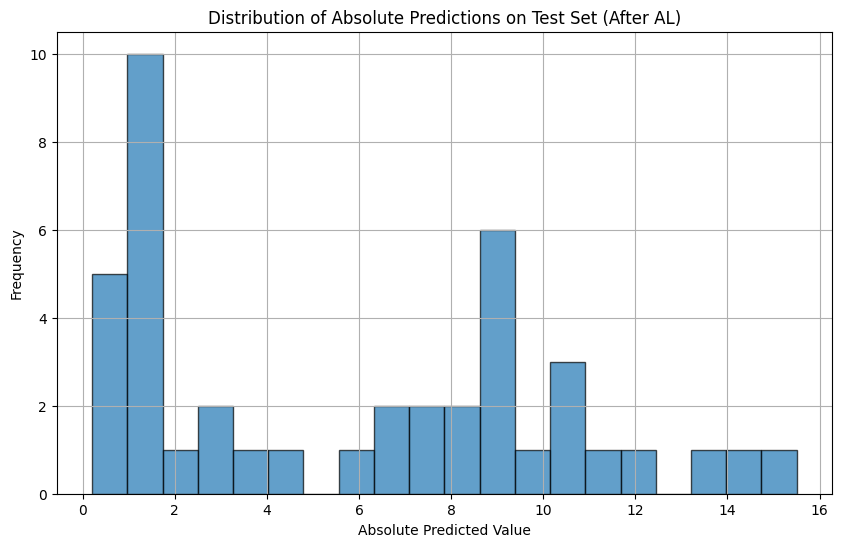

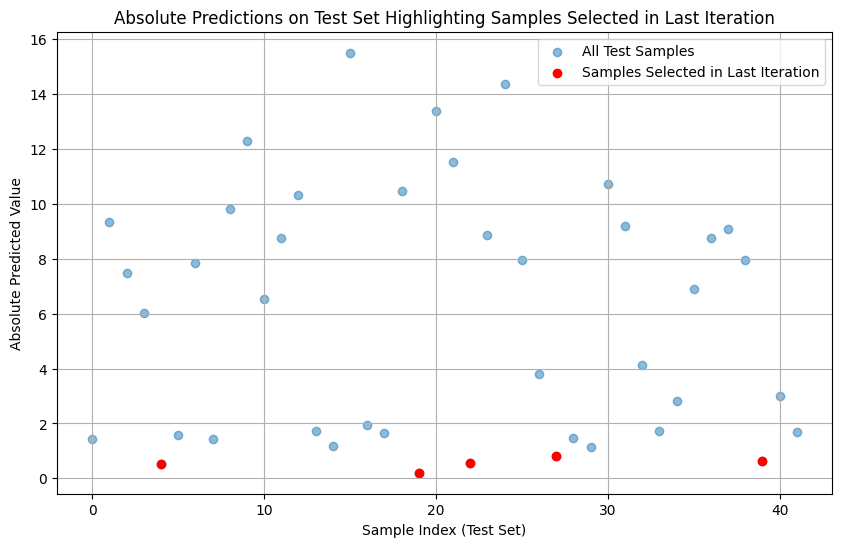

In [26]:
y_pred_test_final = ridge_model.predict(X_test)
abs_y_pred_test_final = np.abs(y_pred_test_final.flatten())

plt.figure(figsize=(10, 6))
plt.hist(abs_y_pred_test_final, bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Absolute Predictions on Test Set (After AL)')
plt.xlabel('Absolute Predicted Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(range(len(abs_y_pred_test_final)), abs_y_pred_test_final, alpha=0.5, label='All Test Samples')
plt.scatter(uncertain_sample_indices, abs_y_pred_test_final[uncertain_sample_indices], color='red', label='Samples Selected in Last Iteration')
plt.title('Absolute Predictions on Test Set Highlighting Samples Selected in Last Iteration')
plt.xlabel('Sample Index (Test Set)')
plt.ylabel('Absolute Predicted Value')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
# Define the parameters for the Gaussian noise
mean = 0.0
std_dev = 1.0

gaussian_noise = np.random.normal(mean, std_dev, y_train.shape)

y_train_noisy = y_train + gaussian_noise

print("Original y_train shape:", y_train.shape)
print("Noisy y_train shape:", y_train_noisy.shape)
print("First 5 original y_train values:\n", y_train[:5])
print("First 5 noisy y_train values:\n", y_train_noisy[:5])

Original y_train shape: (350, 1)
Noisy y_train shape: (350, 1)
First 5 original y_train values:
 [[-3.4459]
 [-5.4459]
 [ 5.5541]
 [11.554 ]
 [12.254 ]]
First 5 noisy y_train values:
 [[-2.50022896]
 [-5.74651152]
 [ 4.31227326]
 [10.67934886]
 [12.16189552]]


MSE of Ordinary Least Squares Model on selected samples (using simulated oracle labels): 8.38412748443517
MSE of Final Active Learning Ridge Model on selected samples (using simulated oracle labels): 8.60025265064119


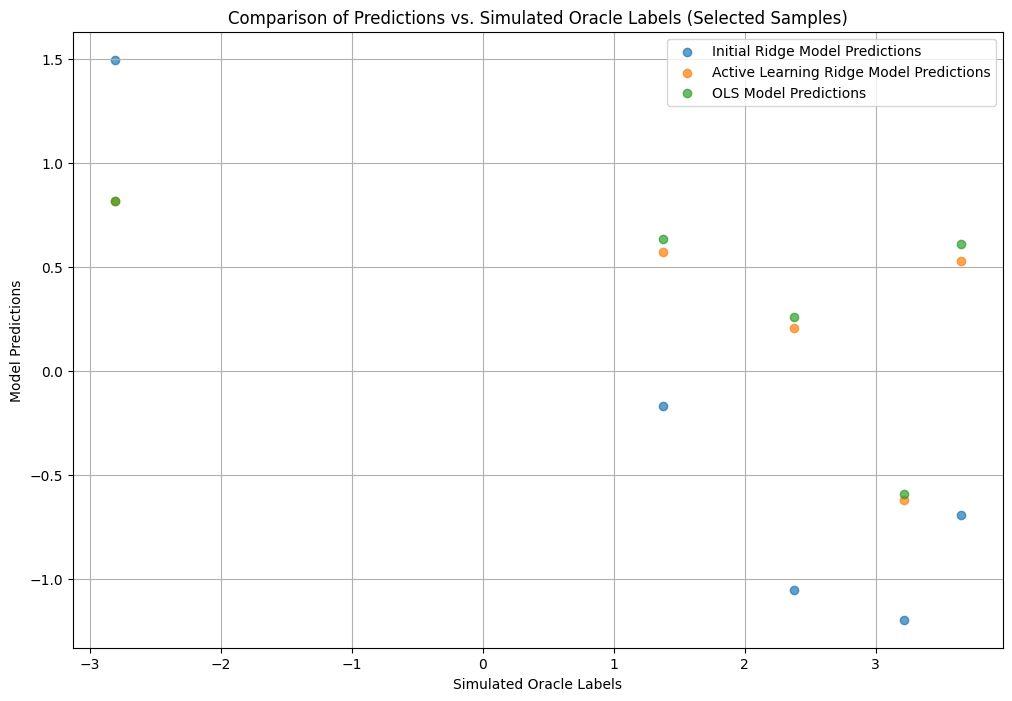

In [27]:
from sklearn.linear_model import LinearRegression

ols_model = LinearRegression()

ols_model.fit(X_train_updated, y_train_updated)

y_pred_ols_selected = ols_model.predict(newly_labeled_X)

mse_ols_on_simulated_labels = mean_squared_error(simulated_oracle_labels, y_pred_ols_selected)

print(f"MSE of Ordinary Least Squares Model on selected samples (using simulated oracle labels): {mse_ols_on_simulated_labels}")
print(f"MSE of Final Active Learning Ridge Model on selected samples (using simulated oracle labels): {mse_on_simulated_labels}")

plt.figure(figsize=(12, 8))
plt.scatter(simulated_oracle_labels, y_pred_initial_selected, label='Initial Ridge Model Predictions', alpha=0.7)
plt.scatter(simulated_oracle_labels, y_pred_selected, label='Active Learning Ridge Model Predictions', alpha=0.7)
plt.scatter(simulated_oracle_labels, y_pred_ols_selected, label='OLS Model Predictions', alpha=0.7)
plt.title('Comparison of Predictions vs. Simulated Oracle Labels (Selected Samples)')
plt.xlabel('Simulated Oracle Labels')
plt.ylabel('Model Predictions')
plt.legend()
plt.grid(True)
plt.show()